# Линейная регрессия

**Если что-то не работает, попробуйте вместо validate написать test, а лучше всего мне -- Данилу Ш.**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Что рассмотрим на этой паре?

* Разбиение на обучающую и тестовую выборки
* Обнаружение мультиколлинеарности
* Регуляризацию
* Сross-validation
* Feature Selection


## Разбиение на обучающую и тестовую выборки

### Advertising Dataset

In [3]:
# read data into a DataFrame
data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


- TV: доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
- Radio: доллары, потраченные на радио рекламу
- Newspaper: доллары, потраченные на рекламу в газетах
- Sales: продажи одного продукта на данном рынке (в тысячах)

**Независимые переменные**: TV, Radio, Newspaper.

**Зависимая переменная**: Sales.

In [4]:
# print the shape of the DataFrame
data.shape

(200, 4)

В нашей выборке 200 **наблюдений**.

### Разбиение

Разбиваем в соотношении 80/20.

In [5]:
from sklearn.model_selection import train_test_split

train_data, validate_data = train_test_split(data, test_size=0.2, random_state=67)
print(train_data.shape)
train_data.head()

(160, 4)


,TV,Radio,Newspaper,Sales
7,57.5,32.8,23.5,11.8
115,78.2,46.8,34.5,14.6
130,59.6,12.0,43.1,9.7
184,287.6,43.0,71.8,26.2
51,199.8,3.1,34.6,11.4


Нужно явно выделить независимые и зависимую переменную, напишем для этого функцию.

In [6]:
def get_features_and_taget(data, column):
    return data.drop([column], axis=1).to_numpy(), data[column].to_numpy()

def get_features_df_and_taget(data, column):
    return data.drop([column], axis=1), data[column].to_numpy()

In [7]:
X_train, Y_train = get_features_and_taget(train_data, "Sales")
X_validate, Y_validate = get_features_and_taget(validate_data, "Sales")

In [8]:
X_train[:10]

array([[ 57.5,  32.8,  23.5],
       [ 78.2,  46.8,  34.5],
       [ 59.6,  12. ,  43.1],
       [287.6,  43. ,  71.8],
       [199.8,   3.1,  34.6],
       [214.7,  24. ,   4. ],
       [ 67.8,  36.6, 114. ],
       [ 38. ,  40.3,  11.9],
       [ 11.7,  36.9,  45.2],
       [199.8,   2.6,  21.2]])

In [9]:
Y_train[:10]

array([11.8, 14.6,  9.7, 26.2, 11.4, 17.4, 12.5, 10.9,  7.3, 10.6])

Обучим модель.

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

Посмотрим на качество:

In [11]:
Y_train_prediced = model.predict(X_train)
Y_validate_prediced = model.predict(X_validate)

from sklearn.metrics import r2_score

print("Train R-squared:", r2_score(Y_train_prediced, Y_train))
print("Test R-squared:", r2_score(Y_validate_prediced, Y_validate))

Train R-squared: 0.8881930192615448
Test R-squared: 0.8846897153845468


## Мультиколлинеарность


Загрузим новый датасет и выведем информацию о нём.

In [12]:
# load dataset
data = pd.read_csv('Car_sales.csv')
data = data.drop('Latest_Launch', axis=1)
# describe dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         157 non-null    object 
 1   Model                157 non-null    object 
 2   Sales_in_thousands   157 non-null    float64
 3   __year_resale_value  121 non-null    float64
 4   Vehicle_type         157 non-null    object 
 5   Price_in_thousands   155 non-null    float64
 6   Engine_size          156 non-null    float64
 7   Horsepower           156 non-null    float64
 8   Wheelbase            156 non-null    float64
 9   Width                156 non-null    float64
 10  Length               156 non-null    float64
 11  Curb_weight          155 non-null    float64
 12  Fuel_capacity        156 non-null    float64
 13  Fuel_efficiency      154 non-null    float64
 14  Power_perf_factor    155 non-null    float64
dtypes: float64(12), object(3)
memory usage: 

Удалим пропуски, посмотрим на размер оставшихся данных.

In [13]:
data = data.dropna()
o_data = data.copy()
data.shape

(117, 15)

Строим тепловую карту корреляций.

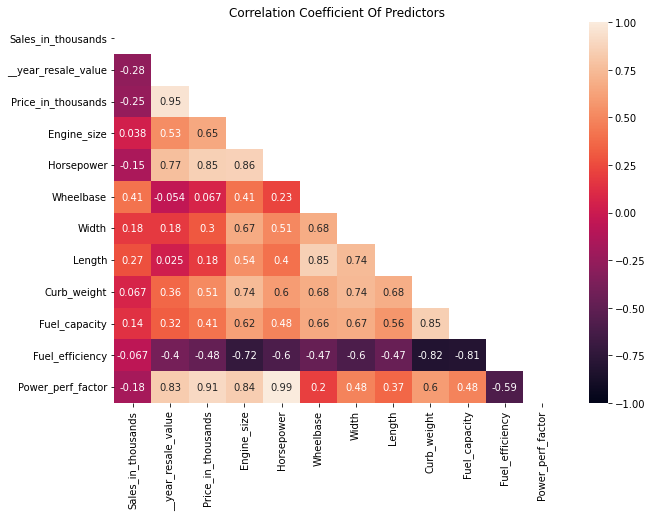

In [14]:
# set figure size
plt.figure(figsize=(10,7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# generate heatmap
sns.heatmap(data.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

Отметим, что есть сильная корреляция между следующими параметрами:

* Power_perf_factor и Horsepower
* Fuel_efficiency и Engine_size
* Fuel_efficiency и Curb_weight
* Fuel_efficiency и Fuel_capacity
  
Обратим внимание на то, что мы выбрали не все параметры с сильной корреляций. 

#### VIF

Variance inflation factor (VIF, коэффициент инфляции дисперсии) -- отношение дисперсии оценки некоторого параметра в модели, включающей несколько других членов (параметров), к дисперсии модели, построенной с использованием только одного члена.

Поскольку нам нужно считать VIF несколько раз, создадим функцию.

$$
\mathrm{Tolerance} = 1 - r^2
$$

$$
\mathrm{VIF} = \frac{1}{\mathrm{Tolerance}}
$$

In [15]:
from sklearn.linear_model import LinearRegression
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

Выводим $\mathrm{VIF}$ для нашего датасета, сортируем по убыванию. 

In [16]:
calculate_vif(df=data, features=['Power_perf_factor','Horsepower','Fuel_efficiency','Engine_size','Curb_weight','Fuel_capacity']).sort_values('VIF', ascending=False)

,VIF,Tolerance
Horsepower,111.471081,0.008971
Power_perf_factor,97.177100,0.010290
Engine_size,6.721330,0.148780
Curb_weight,5.353387,0.186798
Fuel_capacity,4.282718,0.233497
Fuel_efficiency,4.004185,0.249739


Будем считать, что $\mathrm{VIF} > 5$ -- плохо, но убирать сразу все "плохие" признаки нельзя!  

In [17]:
calculate_vif(df=data, features=['Power_perf_factor','Fuel_efficiency','Engine_size','Curb_weight','Fuel_capacity']).sort_values('VIF', ascending=False)

,VIF,Tolerance
Engine_size,5.208420,0.191997
Curb_weight,5.200252,0.192298
Fuel_capacity,4.281471,0.233565
Fuel_efficiency,4.001535,0.249904
Power_perf_factor,3.447764,0.290043


In [18]:
calculate_vif(df=data, features=['Power_perf_factor','Fuel_efficiency','Curb_weight','Fuel_capacity']).sort_values('VIF', ascending=False)

,VIF,Tolerance
Curb_weight,4.769113,0.209683
Fuel_capacity,4.255820,0.234972
Fuel_efficiency,3.787366,0.264036
Power_perf_factor,1.675473,0.596847


Сравним модель без удаления признаков с моделью, где удалили признаки, вызывающие мультиколлинеарность. 

In [19]:
# load libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

df = o_data.copy()

# creating datasets with and without feature removal 

# find all categorical features
cat_var = [var for var in df.columns if df[var].dtypes=='object']

# one hot-encode all categorical features 
ohe = pd.get_dummies(df[cat_var])

#  dataframe with removed features
df_fs = df.drop(['Horsepower', 'Engine_size'], axis = 1)
df_fs = pd.concat([df_fs, ohe], axis=1)
df_fs = df_fs.drop(cat_var, axis=1)

# dataframe without removed features
df = pd.concat([df, ohe], axis=1)
df = df.drop(cat_var, axis=1)

# train test split for both datasets 

X = df.drop('Price_in_thousands', axis=1)
y = df['Price_in_thousands']
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.25, random_state=42)

X_fs = df_fs.drop('Price_in_thousands', axis=1)
y_fs = df_fs['Price_in_thousands']

X_train_fs, X_validate_fs, y_train_fs, y_validate_fs = train_test_split(X_fs, y_fs, test_size=0.25, random_state=42)


### Мин-макс стандартизация

Используем мин-макс стандартизацию, чтобы все признаки были в одной шкале.

$$
X_{\mathrm{std}} = \frac{X - X_{\min}}{X_{\max}-X_{\min}},
$$

$$
X_{\mathrm{scaled}} = X_{\mathrm{std}} \cdot (X_{\max} - X_{\min}) + X_{\min}
$$

In [20]:

# Standardization for both datasets 

mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_validate = mms.transform(X_validate)

mms_fs = MinMaxScaler()
X_train_fs = mms_fs.fit_transform(X_train_fs)
X_validate_fs = mms_fs.transform(X_validate_fs)

Обучаем наши модели.

In [21]:

# making predictions with models for both datasets

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_validate)

lr_fs = LinearRegression()
lr_fs.fit(X_train_fs, y_train_fs)
y_pred_fs = lr_fs.predict(X_validate_fs)

Сравниваем модели по $\mathrm{MSE}$.

In [22]:
# load library
from sklearn.metrics import mean_squared_error

# compute mean_squared errors for both models
mse = mean_squared_error(y_validate, y_pred)
mse_fs = mean_squared_error(y_validate_fs, y_pred_fs)

print('Mean squared error without feature selection: {}'.format(np.round(mse,2)))
print('Mean squared error with feature selection: {}'.format(np.round(mse_fs,2)))

Mean squared error without feature selection: 6.56
Mean squared error with feature selection: 5.77


Получилось, что $\mathrm{MSE}$ в модели с убранными признаками лучше. Так выходит, не всегда. Более интересно для нас сравнение важности признаков до и после удаления признаков.

In [23]:

# find coefficients of each feature in the data without feature selection
importance = lr.coef_
dict_importance = {X.columns[i]:importance[i] for i in range(len(X.columns))}

# find coefficients of each feature in the data with feature selection
importance_fs = lr_fs.coef_
dict_importance_fs = {X_fs.columns[i]:importance_fs[i] for i in range(len(X_fs.columns))}

# features to assess
features = ['__year_resale_value',
        'Wheelbase', 'Width', 'Length', 'Curb_weight',
       'Fuel_capacity', 'Fuel_efficiency']
feature_importance = [dict_importance[feature] for feature in features]
feature_importance_fs = [dict_importance_fs[feature] for feature in features]

# tabulate the coefficient values of each feature with and without feature selection
importance = pd.DataFrame()
importance['Feature'] = features
importance['Feature Importance (Without Feature Selection)'] = feature_importance
importance['Feature Importance (With Feature Selection)'] = feature_importance_fs
importance

,Feature,Feature Importance (Without Feature Selection),Feature Importance (With Feature Selection)
0,__year_resale_value,23.672072,24.681920
1,Wheelbase,-1.564514,-1.653802
2,Width,-1.612609,-0.700809
3,Length,-2.856525,-3.031194
4,Curb_weight,7.188199,8.815405
5,Fuel_capacity,2.238530,3.185959
6,Fuel_efficiency,-2.229290,-3.315188


## Регуляризация (Lasso & Ridge)

### Датасет и его первичная обработка

Воспользуемся набором данных с признаками по недвижимости для предсказания ее стоимости с Kaggle: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Данные заранее разделены на обучающую (train) и тестовую (test) выборки, но в последней нет колонки с зависимой переменной, поскольку это датасет из соревнования.

In [24]:
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('./data/train.csv', index_col=0)
print(f'Размер train: {train.shape}')


Размер train: (1460, 80)


$\mathrm{SalePrice}$ -- наша зависимая переменная. Полное описание всех 79 признаков в данных можно посмотреть на [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

Чтобы улучшить качествоваших прогнозов можно:

1. Найти и удалить выбросы
2. Заполнить пропущенные значения
3. Добавить новые признаки

#### 1. Удаляем выбросы

Покажем этот шаг на примере с одним признаком - жилой площадью. То же самое можно проделать по остальным признакам.   

Значение z-score +/- 3 обычно рассматривается как выброс. 

In [25]:
train.shape[0]

1460

In [26]:
from scipy import stats

z_scores = stats.zscore(train['GrLivArea'])
train['z_score'] = np.abs(z_scores)
print('Было 1460, осталось', train[train.z_score < 3].shape[0], 'наблюдения')

Было 1460, осталось 1444 наблюдения


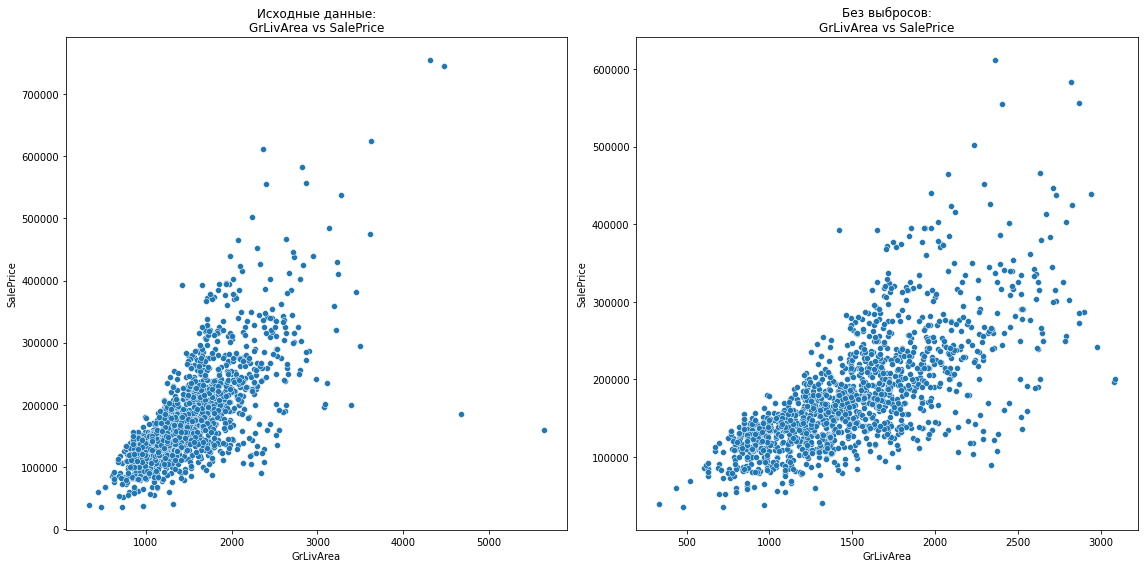

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title('Исходные данные:\nGrLivArea vs SalePrice')

plt.subplot(1, 2, 2)
sns.scatterplot(x=train[train.z_score < 3]['GrLivArea'], y=train['SalePrice'])
plt.title('Без выбросов:\nGrLivArea vs SalePrice')
plt.tight_layout()

In [28]:
train = train[train.z_score < 3]
train.drop(columns='z_score', inplace=True)

#### 2. Посмотрим наличие пропущенных значений

In [29]:
train.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      257
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

Колонок слишком много, отсортируем по количеству пропусков по убыванию. 

In [30]:
sorted(dict(train.isnull().sum()).items(), key=lambda x: x[1], reverse=True)[:20]

[('PoolQC', 1440),
 ('MiscFeature', 1390),
 ('Alley', 1354),
 ('Fence', 1167),
 ('FireplaceQu', 689),
 ('LotFrontage', 257),
 ('GarageType', 80),
 ('GarageYrBlt', 80),
 ('GarageFinish', 80),
 ('GarageQual', 80),
 ('GarageCond', 80),
 ('BsmtExposure', 38),
 ('BsmtFinType2', 38),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtFinType1', 37),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('Electrical', 1),
 ('MSSubClass', 0)]

Взглянем на описание данных из документации, где рекомендованы разные стратегии по заполнению пропущенных значений:

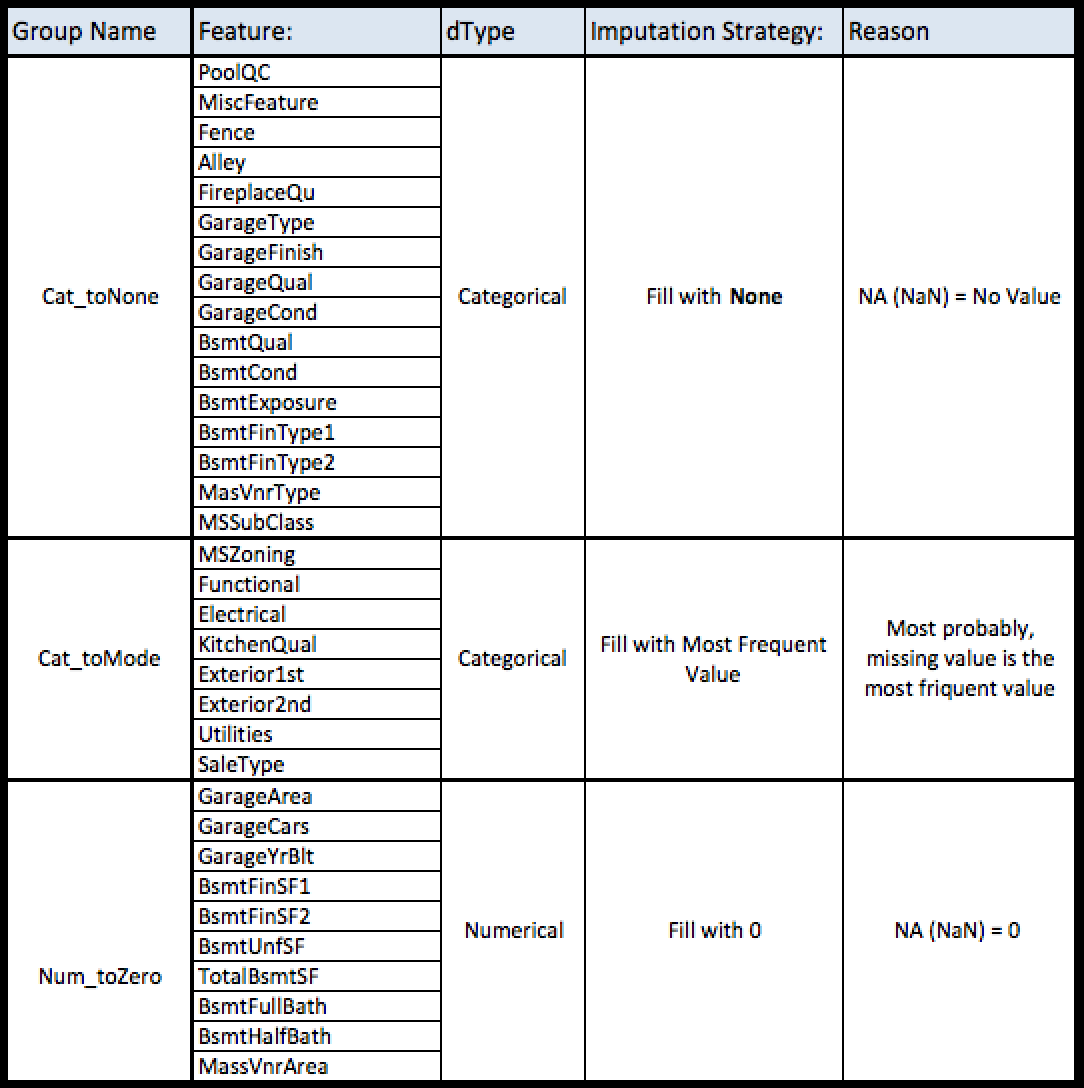

In [31]:
from IPython.display import Image
Image("./data/data_desc.png", height=800 , width=600)

Заполним пропущенные значения в соответствии со стратегиями выше:

In [32]:
cat_to_none = ('PoolQC', 'MiscFeature', 'Fence', 'Alley', 'FireplaceQu', 'GarageType', 'GarageFinish',
              'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
              'BsmtFinType2', 'MasVnrType', 'MSSubClass')
    
cat_to_mode = ('MSZoning', 'Functional', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
              'Utilities', 'SaleType')

num_to_zero = ('GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
              'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'MasVnrArea')

for col in cat_to_none:
    train[col] = train[col].fillna('None')

for col in cat_to_mode:
    train[col] = train[col].fillna(train[col].mode()[0])
    
for col in num_to_zero:
    train[col] = train[col].fillna(0)


* По переменной **LotFrontage** нужен дополнительный анализ

Поскольку LotFrontage - это расстояние до двора дома, мы можем сделать предположение, что оно зависит от района, в котором расположен дом. Таким образом, мы можем сгруппировать значения LotFrontage по признаку соседства и заменить отсутствующие значения на медианное расстояние LotFrontage по соседству.

In [33]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#### 3. Добавить собственные признаки

Total_SF -- общий метраж дома.

In [34]:
train['Total_SF'] = (train['1stFlrSF'] + train['2ndFlrSF'] + 
                       + train['TotalBsmtSF'] + train['GarageArea'] + 
                       + train['GrLivArea'] + train['PoolArea'] + train['WoodDeckSF'])

Почему в линейной регрессии данный признак не имеет пользы?

Нужно сделать дамми переменные, потому что у нас куча категориальных признаков.

In [35]:
train = pd.get_dummies(train)

## Ridge и Lasso


Начнем с обучения простой регрессии. 

In [36]:
train_data, validate_data = train_test_split(train, test_size=0.2, random_state=67)

from sklearn.linear_model import ElasticNet, Lasso, Ridge

X_train, Y_train = get_features_and_taget(train_data, "SalePrice")
X_validate, Y_validate = get_features_and_taget(validate_data, "SalePrice")

model = LinearRegression()
model.fit(X_train, Y_train)

Y_train_prediced = model.predict(X_train)
Y_validate_prediced = model.predict(X_validate)

print("Train R-squared", r2_score(Y_train_prediced, Y_train))
print("Test R-squared", r2_score(Y_validate_prediced, Y_validate))

Train R-squared 0.9470212062969958
Test R-squared 0.8605645200527005


Вроде всё хорошо, но вдруг переобучение уже есть? Давайте проверим. **Тут важно стандартизировать все признаки**.

In [37]:
from sklearn.preprocessing import StandardScaler

train_data, validate_data = train_test_split(train, test_size=0.2, random_state=67)

X_train, Y_train = get_features_and_taget(train_data, "SalePrice")
X_validate, Y_validate = get_features_and_taget(validate_data, "SalePrice")

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_validate = scaler_x.transform(X_validate)


# We scale target just for more "usual" alpha values
scaler_y = StandardScaler()
Y_train = scaler_y.fit_transform(Y_train.reshape((-1,1))).reshape(-1) #fir_transform ~~ fit().transform()
Y_validate = scaler_y.transform(Y_validate.reshape((-1,1))).reshape(-1)

model = Lasso(alpha=0.01) # just change me to any other model
model.fit(X_train, Y_train)

Y_train_predicted = model.predict(X_train)
Y_validate_predicted = model.predict(X_validate)

print("Train R-squared", r2_score(Y_train_predicted, Y_train))
print("Test R-squared", r2_score(Y_validate_predicted, Y_validate))

Train R-squared 0.9300564151279308
Test R-squared 0.862831851441336


In [38]:
model = Ridge(alpha=14) # just change me to any other model
model.fit(X_train, Y_train)


Y_train_predicted = model.predict(X_train)
Y_validate_predicted = model.predict(X_validate)

print("Train R-squared", r2_score(Y_train_predicted, Y_train))
print("Test R-squared", r2_score(Y_validate_predicted, Y_validate))

Train R-squared 0.9465988174373147
Test R-squared 0.8607318181110784


Стало лучше, а давайте подберем оптимальный параметр альфы!

Подсказка: logspace(x) -- $10^x$.

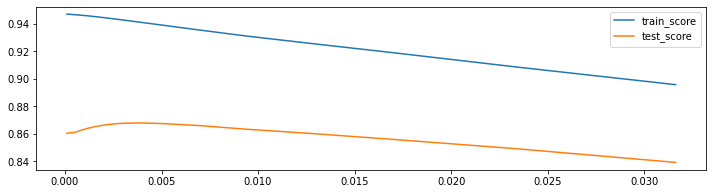

In [39]:
runs = []

for alpha in np.logspace(-4, -1.5, 20):

    model = Lasso(alpha=alpha) # change me between Ridge and Lasso
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_validate_prediced = model.predict(X_validate)
    
    runs.append({
        "alpha": alpha,
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_validate_prediced, Y_validate),
    })
    
    
plt.figure(figsize=(12,3))
plt.plot([run["alpha"] for run in runs], [run["train_score"] for run in runs], label="train_score")
plt.plot([run["alpha"] for run in runs], [run["test_score"] for run in runs], label="test_score")
plt.legend()
plt.show()


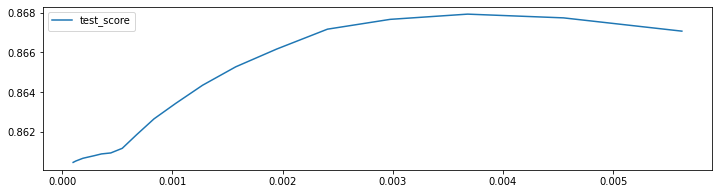

In [40]:
runs = []
for alpha in np.logspace(-4, -2.25, 20):

    model = Lasso(alpha=alpha) 
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_validate_prediced = model.predict(X_validate)

    runs.append({
        "alpha": alpha,
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_validate_prediced, Y_validate),
    })
    
    
plt.figure(figsize=(12,3))
plt.plot([run["alpha"] for run in runs], [run["test_score"] for run in runs], label="test_score")
plt.legend()
plt.show()

Попробуем $\mathrm{Lasso}$ при $\alpha = 0.0035$.

In [41]:
model = Lasso(alpha=0.0035) 
model.fit(X_train, Y_train)


Y_train_predicted = model.predict(X_train)
Y_validate_predicted = model.predict(X_validate)

print("Train R-squared", r2_score(Y_train_predicted, Y_train))
print("Test R-squared", r2_score(Y_validate_predicted, Y_validate))

Train R-squared 0.9417995194955706
Test R-squared 0.8678829081126891


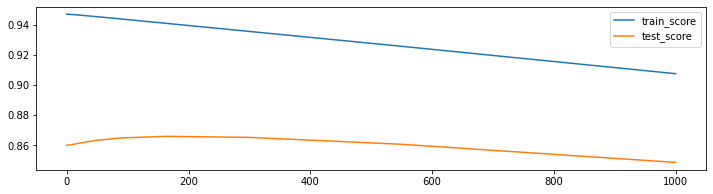

In [42]:
runs = []

for alpha in np.logspace(-2, 3, 20):

    model = Ridge(alpha=alpha) # change me between Ridge and Lasso
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_validate_prediced = model.predict(X_validate)
    
    runs.append({
        "alpha": alpha,
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_validate_prediced, Y_validate),
    })
    
    
plt.figure(figsize=(12,3))
plt.plot([run["alpha"] for run in runs], [run["train_score"] for run in runs], label="train_score")
plt.plot([run["alpha"] for run in runs], [run["test_score"] for run in runs], label="test_score")
plt.legend()
plt.show()


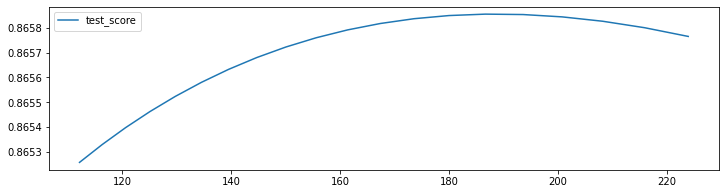

In [43]:
runs = []

for alpha in np.logspace(2.05, 2.35, 20):

    model = Ridge(alpha=alpha) # change me between Ridge and Lasso
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_validate_prediced = model.predict(X_validate)
    
    runs.append({
        "alpha": alpha,
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_validate_prediced, Y_validate),
    })
    
    
plt.figure(figsize=(12,3))
plt.plot([run["alpha"] for run in runs], [run["test_score"] for run in runs], label="test_score")
plt.legend()
plt.show()


Пробуем $\mathrm{Ridge}$ при $\alpha=190$.

In [44]:
model = Ridge(alpha=190)
model.fit(X_train, Y_train)

Y_train_predicted = model.predict(X_train)
Y_validate_predicted = model.predict(X_validate)

print("Train R-squared", r2_score(Y_train_predicted, Y_train))
print("Test R-squared", r2_score(Y_validate_predicted, Y_validate))

Train R-squared 0.9398467259145352
Test R-squared 0.865854969448365


Теперь посмотрим, как меняются коэффициенты при разных уровнях альфы, для ридж (np.logspace(-2, 5, 20)) и для лассо (np.logspace(-2, 0.2, 20)):



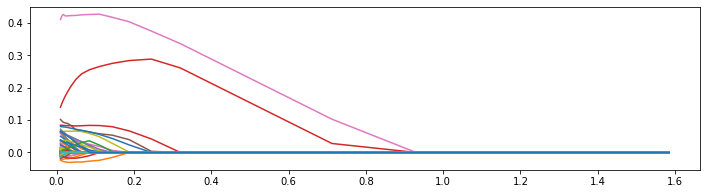

In [45]:
runs = []

for alpha in np.logspace(-2, 0.2, 20):

    model = Lasso(alpha=alpha) # change me between Ridge and Lasso
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_validate_prediced = model.predict(X_validate)

    runs.append({
        "alpha": alpha,
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_validate_prediced, Y_validate),
    })


plt.figure(figsize=(12,3))
plt.plot([run["alpha"] for run in runs], [run["coef"] for run in runs])
plt.show()

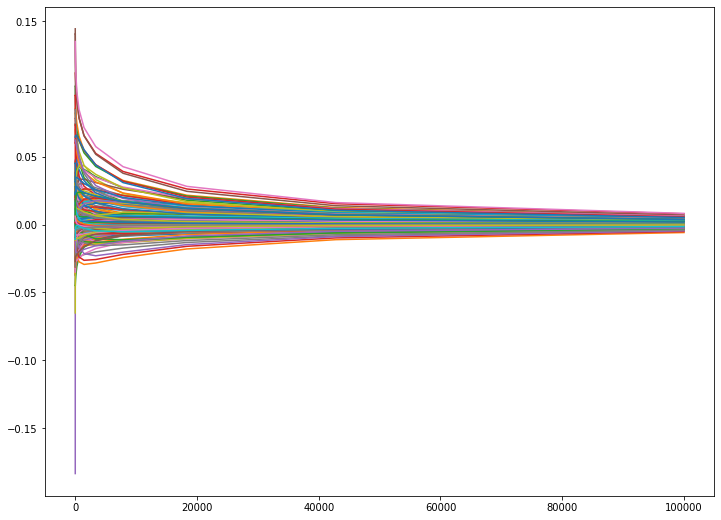

In [46]:
runs = []

for alpha in np.logspace(-2, 5, 20):

    model = Ridge(alpha=alpha) # change me between Ridge and Lasso
    model.fit(X_train, Y_train)

    Y_train_prediced = model.predict(X_train)
    Y_validate_prediced = model.predict(X_validate)
    
    runs.append({
        "alpha": alpha,
        "coef": model.coef_,
        "train_score": r2_score(Y_train_prediced, Y_train),
        "test_score": r2_score(Y_validate_prediced, Y_validate),
    })


plt.figure(figsize=(12,9))
plt.plot([run["alpha"] for run in runs], [run["coef"] for run in runs])
plt.show()

### Еще немного визуализации

Давайте постоим график лассо или ридж регрессии, с один предиктором

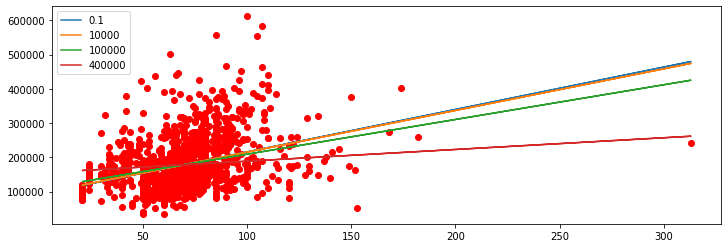

In [47]:
FEATURE_INDEX = 1

X, Y = get_features_and_taget(train, "SalePrice")

X = X[:, [FEATURE_INDEX]]

plt.figure(figsize=(12, 4))
plt.scatter(X, Y, color = "red")
for alpha in [0.1, 10000, 100000, 400000]: 
    model = Lasso(alpha=alpha)
    model.fit(X, Y)
    plt.plot(X, model.predict(X), label = alpha)

plt.legend()
plt.show()

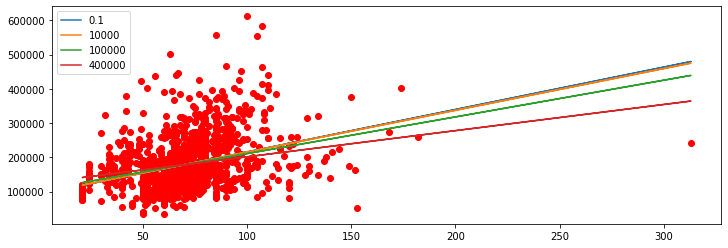

In [48]:
FEATURE_INDEX = 1

X, Y = get_features_and_taget(train, "SalePrice")

X = X[:, [FEATURE_INDEX]]

plt.figure(figsize=(12, 4))
plt.scatter(X, Y, color = "red")
for alpha in [0.1, 10000, 100000, 400000]: 
    model = Ridge(alpha=alpha)
    model.fit(X, Y)
    plt.plot(X, model.predict(X), label = alpha)

plt.legend()
plt.show()


## 3. Кросс-валидация
 
 
Предположим, мы подобрали оптимальный параметр. **А чтоб если мы бы разбили выборку по-другому?** 

**Кросс-валидация** (или скользящий контроль) — это процедура оценивания обобщающей способности модели, она бывает нескольких видов. Валидация на отложенных данных (**Hold-Out Validation**) - это когда мы один раз случайным образом делим выборку на train и test. 
Сегодня мы попробуем другой вид - **k-fold кросс-валидация**. 

1. Обучающая выборка разбивается на k непересекающихся одинаковых по объему частей;<br>
2. Производится k итераций. На каждой итерации происходит следующее: <br>
    2.1 Модель обучается на k−1 части обучающей выборки; <br>
    2.2 Модель тестируется на части обучающей выборки, которая не участвовала в обучении.<br>

Каждая из k частей единожды используется для тестирования. Как правило, k=10 (5 в случае малого размера выборки).

![](https://long-short.pro/wp-content/uploads/sites/3/2013/06/crossvalidation.png)

In [49]:
from sklearn.model_selection import cross_validate

model = Lasso(alpha=0.0035)
cv_results = cross_validate(model, X_train, Y_train, cv=4)
cv_results

{'fit_time': array([0.24887371, 0.11293197, 0.08394933, 0.16081929]),
 'score_time': array([0.00098634, 0.        , 0.00101686, 0.00099921]),
 'test_score': array([0.90935421, 0.90863495, 0.9208866 , 0.9177428 ])}

In [50]:
model = Ridge(alpha=190)
cv_results = cross_validate(model, X_train, Y_train, cv=4)
cv_results

{'fit_time': array([0.02697468, 0.02253461, 0.03198195, 0.02098894]),
 'score_time': array([0.00100136, 0.00199246, 0.0009985 , 0.00099826]),
 'test_score': array([0.90533143, 0.9179398 , 0.91568026, 0.91253591])}

## Feature selection

Библиотека

In [51]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

* $\mathrm{k\_features}$ -- сколько признаков оставить,
* $\mathrm{forward}$ (bool) -- направление,
* $\mathrm{scoring}$ -- оценка,
* $\mathrm{cv}$ -- разбить на ... кросс-валидации,
* $\mathrm{n\_jobs}$ -- многопоток (-1 -- все доступные, по умолчанию: 1).

In [52]:
train_data, validate_data = train_test_split(train, test_size=0.2, random_state=67)

X_train, Y_train = get_features_df_and_taget(train_data, "SalePrice")
X_test, Y_validate = get_features_df_and_taget(validate_data, "SalePrice")

model = LinearRegression()

sfs = SFS(model, 
          k_features=10, 
          forward=True, 
          scoring='r2',
          cv=5,
          n_jobs=-1)

In [53]:
sfs = sfs.fit(X_train, Y_train)

pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(36,)","[0.6835498622890248, 0.6601053701559092, 0.728...",0.683632,"(Total_SF,)",0.063295,0.049246,0.024623
2,"(3, 36)","[0.7961326338533689, 0.7922410794101792, 0.808...",0.793955,"(OverallQual, Total_SF)",0.045246,0.035203,0.017602
3,"(3, 36, 183)","[0.8138802062308435, 0.8281541889494042, 0.836...",0.826643,"(OverallQual, Total_SF, BsmtQual_Ex)",0.039009,0.03035,0.015175
4,"(3, 8, 36, 183)","[0.8224753623122242, 0.850486305713537, 0.8442...",0.844179,"(OverallQual, BsmtFinSF1, Total_SF, BsmtQual_Ex)",0.039309,0.030583,0.015292
5,"(3, 8, 36, 183, 292)","[0.8460887277923962, 0.8622146590117059, 0.853...",0.856423,"(OverallQual, BsmtFinSF1, Total_SF, BsmtQual_E...",0.033771,0.026275,0.013138
6,"(3, 8, 21, 36, 183, 292)","[0.8469048114693187, 0.8700284456379326, 0.861...",0.86505,"(OverallQual, BsmtFinSF1, KitchenAbvGr, Total_...",0.02834,0.022049,0.011025
7,"(3, 6, 8, 21, 36, 183, 292)","[0.8519808266867928, 0.8857258709468089, 0.867...",0.870913,"(OverallQual, YearRemodAdd, BsmtFinSF1, Kitche...",0.029013,0.022573,0.011287
8,"(2, 3, 6, 8, 21, 36, 183, 292)","[0.8568303722801015, 0.8910440395843161, 0.869...",0.8775,"(LotArea, OverallQual, YearRemodAdd, BsmtFinSF...",0.031269,0.024328,0.012164
9,"(2, 3, 6, 8, 21, 36, 183, 230, 292)","[0.8665960564573711, 0.8885563453749, 0.878489...",0.883041,"(LotArea, OverallQual, YearRemodAdd, BsmtFinSF...",0.027962,0.021755,0.010878
10,"(2, 3, 5, 6, 8, 21, 36, 183, 230, 292)","[0.8643015418403872, 0.8932270260313343, 0.883...",0.886715,"(LotArea, OverallQual, YearBuilt, YearRemodAdd...",0.026959,0.020975,0.010488


In [54]:
sfs = SFS(model, 
          k_features=297, 
          forward=False, 
          scoring='r2',
          cv=5,
          n_jobs=-1)

In [55]:
sfs = sfs.fit(X_train, Y_train)

res = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [56]:
res

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
301,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8788247779533818, 0.8969633467678294, 0.901...",0.895864,"(MSSubClass, LotFrontage, LotArea, OverallQual...",0.019466,0.015145,0.007573
300,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8790594936952058, 0.8990308244556735, 0.901...",0.89664,"(MSSubClass, LotFrontage, LotArea, OverallQual...",0.019023,0.014801,0.0074
299,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8794466266606735, 0.902101291345597, 0.9016...",0.897407,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.018859,0.014673,0.007336
298,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8836936254401947, 0.9019871501349447, 0.900...",0.898076,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.017955,0.01397,0.006985
297,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8858504060899355, 0.9019871501349427, 0.900...",0.898508,"(LotFrontage, LotArea, OverallQual, OverallCon...",0.01741,0.013546,0.006773


***
*По хорошему, здесь должны быть выводы о качестве построенной модели и вот это вот всё, но конкретно с этим датасетом у меня есть работа получше, я её также выложу в гитхаб. PCA и random forest там откровенно плох, на них внимания обращать не надо. Там только регуляризация, правильное разбиение на train, validate и test, и fsfs.*
***


## Используемые источники

* Kagle
* towardsdatascience
* medium
* Statistics for Business and Economics, Eleventh Edition David R. Anderson, Dennis J. Sweeney, Thomas A. Williams